In [1]:
import os
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# --- Configuration ---
DATASET_DIR = "Rust_Dataset"
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 16
EPOCHS = 25
LEARNING_RATE = 0.0001
NUM_CLASSES = 4
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]

print("Configuration loaded successfully!")

Configuration loaded successfully!


In [2]:
# Select Device (CPU/GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Data Setup
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize(NORM_MEAN, NORM_STD)
    ]),
    'valid': transforms.Compose([
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transforms.ToTensor(),
        transforms.Normalize(NORM_MEAN, NORM_STD)
    ]),
    'test': transforms.Compose([
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transforms.ToTensor(),
        transforms.Normalize(NORM_MEAN, NORM_STD)
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(DATASET_DIR, x), data_transforms[x])
                  for x in ['train', 'valid', 'test']}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=(x == 'train'), num_workers=2)
               for x in ['train', 'valid']}

test_loader = DataLoader(image_datasets['test'], batch_size=1, shuffle=False, num_workers=0)

print(f"Training samples: {len(image_datasets['train'])}")
print(f"Validation samples: {len(image_datasets['valid'])}")
print(f"Test samples: {len(image_datasets['test'])}")

Training samples: 438
Validation samples: 123
Test samples: 63


In [4]:
# Model Construction
model = models.resnet50(weights='IMAGENET1K_V1')

for param in model.parameters():
    param.requires_grad = False
    
# ResNet50 uses 'fc' as the final fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, NUM_CLASSES)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=LEARNING_RATE)

print("Model loaded and configured successfully!")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

Model loaded and configured successfully!
Total parameters: 23,516,228


In [5]:
# Training Loop with Validation Loss and Accuracy
print("Starting training...")
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in dataloaders['train']:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    epoch_loss = running_loss / len(image_datasets['train'])
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    
    # Validation loss and accuracy
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for val_inputs, val_labels in dataloaders['valid']:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            val_running_loss += val_loss.item() * val_inputs.size(0)
            _, val_predicted = torch.max(val_outputs, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()
    val_epoch_loss = val_running_loss / len(image_datasets['valid'])
    val_epoch_acc = val_correct / val_total
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc)
    
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {epoch_loss:.4f} - Val Loss: {val_epoch_loss:.4f} - Acc: {epoch_acc:.4f} - Val Acc: {val_epoch_acc:.4f}")

print("Training completed!")

Starting training...


c:\4 - CODING FILES\SOFTWARE-DESIGN1\.venv\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 1/25 - Loss: 1.3243 - Val Loss: 1.2890 - Acc: 0.3219 - Val Acc: 0.3902
Epoch 2/25 - Loss: 1.2260 - Val Loss: 1.1942 - Acc: 0.3881 - Val Acc: 0.4228
Epoch 3/25 - Loss: 1.1364 - Val Loss: 1.1099 - Acc: 0.4703 - Val Acc: 0.5041
Epoch 4/25 - Loss: 1.0580 - Val Loss: 1.0460 - Acc: 0.5685 - Val Acc: 0.5366
Epoch 5/25 - Loss: 1.0120 - Val Loss: 0.9755 - Acc: 0.6324 - Val Acc: 0.6098
Epoch 6/25 - Loss: 0.9446 - Val Loss: 0.9379 - Acc: 0.6507 - Val Acc: 0.6911
Epoch 7/25 - Loss: 0.9274 - Val Loss: 0.9014 - Acc: 0.6758 - Val Acc: 0.7073
Epoch 8/25 - Loss: 0.8708 - Val Loss: 0.8715 - Acc: 0.6895 - Val Acc: 0.6911
Epoch 9/25 - Loss: 0.8446 - Val Loss: 0.8438 - Acc: 0.7192 - Val Acc: 0.6585
Epoch 10/25 - Loss: 0.8021 - Val Loss: 0.8142 - Acc: 0.7420 - Val Acc: 0.6992
Epoch 11/25 - Loss: 0.7754 - Val Loss: 0.7920 - Acc: 0.7352 - Val Acc: 0.6992
Epoch 12/25 - Loss: 0.7811 - Val Loss: 0.7732 - Acc: 0.7283 - Val Acc: 0.7073
Epoch 13/25 - Loss: 0.7569 - Val Loss: 0.7555 - Acc: 0.7511 - Val Acc: 0.

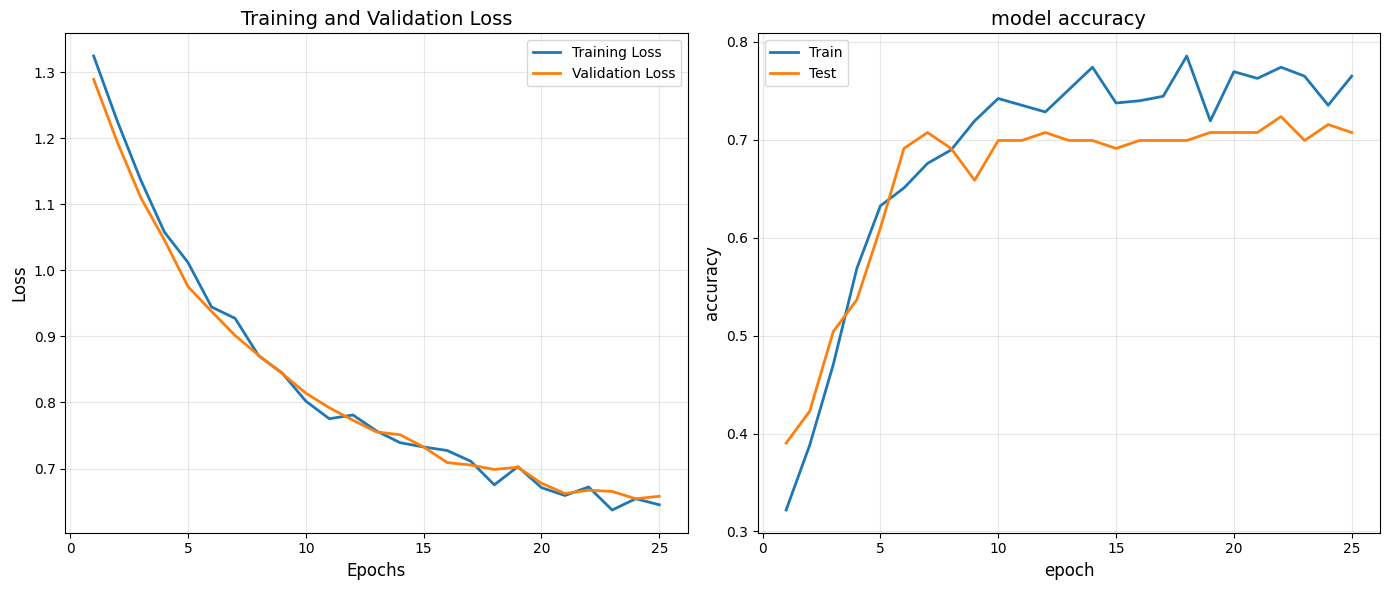

Final Training Loss: 0.6452
Final Validation Loss: 0.6581
Final Training Accuracy: 0.7648
Final Validation Accuracy: 0.7073


In [6]:
# Plot Training and Validation Loss and Accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Loss plot
ax1.plot(range(1, EPOCHS+1), train_losses, label='Training Loss', linewidth=2)
ax1.plot(range(1, EPOCHS+1), val_losses, label='Validation Loss', linewidth=2)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Validation Loss', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(range(1, EPOCHS+1), train_accuracies, label='Train', linewidth=2)
ax2.plot(range(1, EPOCHS+1), val_accuracies, label='Test', linewidth=2)
ax2.set_xlabel('epoch', fontsize=12)
ax2.set_ylabel('accuracy', fontsize=12)
ax2.set_title('model accuracy', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Validation Loss: {val_losses[-1]:.4f}")
print(f"Final Training Accuracy: {train_accuracies[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.4f}")

In [7]:
def calculate_map(model, dataloader, device):
    """Calculates Mean Average Precision using 'scikit-learn'."""
    try:
        from sklearn.metrics import average_precision_score
        from sklearn.preprocessing import label_binarize
        
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                outputs = torch.softmax(model(inputs), dim=1)
                all_preds.append(outputs.cpu().numpy())
                all_labels.append(labels.numpy())
        
        y_pred_probs = np.concatenate(all_preds)
        y_true = np.concatenate(all_labels)
        y_true_bin = label_binarize(y_true, classes=range(NUM_CLASSES))
        return average_precision_score(y_true_bin, y_pred_probs, average="macro")
    except ImportError:
        print("[WARN] 'scikit-learn' not installed. Skipping Performance (mAP) metric.")
        return 0.0

def calculate_code_metrics():
    """Calculates code complexity metrics using 'radon'."""
    try:
        import radon.complexity as cc
        import radon.metrics as mi
        # Read the original .py file for analysis
        py_file = 'resnet_50.py'
        if os.path.exists(py_file):
            with open(py_file, 'r') as f:
                code = f.read()
            complexity_data = cc.cc_visit(code)
            avg_cc = np.mean([item.complexity for item in complexity_data]) if complexity_data else 0
            maintainability_index = mi.mi_visit(code, multi=False)
            return avg_cc, maintainability_index
        else:
            print("[WARN] Original .py file not found for code metrics.")
            return 0, 0
    except ImportError:
        print("[WARN] 'radon' not installed. Skipping Functionality & Compatibility metrics.")
        return 0, 0

print("Metric functions defined successfully!")

Metric functions defined successfully!


In [8]:
# Calculate Metrics
print("Calculating metrics...")

# A. Manufacturability
total_params = sum(p.numel() for p in model.parameters())

# B. Efficiency
model.eval()
start_time = time.time()
steps_to_test = 50
with torch.no_grad():
    for i, (inputs, _) in enumerate(test_loader):
        if i >= steps_to_test: break
        inputs = inputs.to(device)
        _ = model(inputs)
end_time = time.time()
avg_inference_time_ms = ((end_time - start_time) / steps_to_test) * 1000

# C. Performance (mAP)
mAP = calculate_map(model, test_loader, device)

# D & E. Functionality & Compatibility
avg_cc, maint_index = calculate_code_metrics()

print("Metrics calculated successfully!")

Calculating metrics...
Metrics calculated successfully!


In [9]:
# Final Report
print("\n" + "="*50)
print("RUST DETECTION MODEL: RESNET50 (PyTorch)")
print("="*50)
print(f"1. Manufacturability (Model Complexity): {total_params:,} parameters")
print(f"2. Efficiency (Avg Inference Time):      {avg_inference_time_ms:.2f} ms/image")
print(f"3. Performance (Mean Average Precision): {mAP:.4f}")
print(f"4. Functionality (Cyclomatic Complexity):{avg_cc:.2f} (Avg per block)")
print(f"5. Compatibility (Maintainability Index):{maint_index:.2f} (Scale 0-100)")
print("="*50)


RUST DETECTION MODEL: RESNET50 (PyTorch)
1. Manufacturability (Model Complexity): 23,516,228 parameters
2. Efficiency (Avg Inference Time):      10.49 ms/image
3. Performance (Mean Average Precision): 0.8373
4. Functionality (Cyclomatic Complexity):4.00 (Avg per block)
5. Compatibility (Maintainability Index):47.36 (Scale 0-100)


In [10]:
# Save model
torch.save(model.state_dict(), 'rust_resnet50.pth')
print("Model saved to rust_resnet50.pth")

Model saved to rust_resnet50.pth
